In [42]:
import sys
sys.path.insert(0, "../")
import utils
import geopandas
from shapely.geometry import box, mapping
from dask import dataframe as dd
from dask.system import cpu_count
from dask.distributed import Client, LocalCluster
import rioxarray
import xarray
from numpy import percentile
from download import download
import os
import subprocess
import numpy as np

In [2]:
local_dir = "../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/"

In [3]:
tiles = geopandas.read_file("../../data_processing/imagery/GHS-composite-S2.geojson")

In [4]:
medellin = geopandas.read_parquet("../../urbangrammar_samba/sp_sig_concept/medellin/nodes.pq")
houston = geopandas.read_parquet("../../urbangrammar_samba/sp_sig_concept/houston/enclosures.pq")
dar_es_salaam = geopandas.read_parquet("../../urbangrammar_samba/sp_sig_concept/dar_es_salaam/nodes.pq")

In [5]:
med_extent = geopandas.GeoSeries(box(*medellin.total_bounds), crs=medellin.crs).to_crs(tiles.crs).iloc[0]
houston_extent = geopandas.GeoSeries(box(*houston.total_bounds), crs=houston.crs).to_crs(tiles.crs).iloc[0]
dar_es_salaam_extent = geopandas.GeoSeries(box(*dar_es_salaam.total_bounds), crs=dar_es_salaam.crs).to_crs(tiles.crs).iloc[0]

## Medellin

In [6]:
meta = tiles[tiles.intersects(med_extent)]

In [7]:
meta["dst_path"] = meta["URL"].apply(lambda x: local_dir+x.split("/")[-1])

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [10]:
meta

URL   EPSG UTMtile  \
997  http://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendat...  32618     18N   

         minX      minY      maxX      maxY      size  size_unit  size_bytes  \
997  398970.0  652550.0  631930.0  885510.0  3.028459  gigabytes  3251783540   

                                              geometry  \
997  POLYGON ((-73.80819 5.90234, -73.80286 8.00923...   

                                              dst_path  
997  ../../urbangrammar_samba/sp_sig_concept/ghs_co...

In [12]:
out = meta.apply(utils.process_scene, 
                   axis=1,
                   t_crs="EPSG:3117",
                   progressbar=True,
                  )

14/01/2021 14:21:06 | Working on Tile 18N - File: S2_percentile_30_UTM_557-0000000000-0000023296.tif
Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.
	14/01/2021 14:21:06 | rio warp ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_30_UTM_557-0000000000-0000023296.tif ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_30_UTM_557-0000000000-0000023296_osgb.tif --threads 16 --dst-crs EPSG:3117
	14/01/2021 14:27:38 | rm ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_30_UTM_557-0000000000-0000023296.tif
	Split-opt.
		14/01/2021 14:30:09 | Optimising S2_percentile_30_UTM_557-0000000000-0000023296_wm_R.tif


		14/01/2021 14:33:15 | Optimising S2_percentile_30_UTM_557-0000000000-0000023296_wm_G.tif


		14/01/2021 14:36:13 | Optimising S2_percentile_30_UTM_557-0000000000-0000023296_wm_B.tif


		14/01/2021 14:39:23 | Optimising S2_percentile_30_UTM_557-0000000000-0000023296_wm_I.tif


In [6]:
r = rioxarray.open_rasterio("../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_30_UTM_557-0000000000-0000023296_osgb.tif")

In [7]:
sub = r.sel(band=[1, 2, 3]).rio.clip_box(*medellin.total_bounds)

In [20]:
def minmax(a, 
           bottom=0, 
           top=255, 
           min_cut=2.5, 
           max_cut=98.5
          ):
    vals = a.to_series().values
    min_bin = percentile(vals, min_cut)
    max_bin = percentile(vals, max_cut)
    a = xarray.where(a > max_bin, max_bin, a)
    a = xarray.where(a < min_bin, min_bin, a)
    a_std = (a - a.min()) / (a.max() - a.min())
    a_scaled = a_std * (top - bottom) + bottom
    return a_scaled.astype(int)

# sub.groupby("band")\
#    .map(minmax)\
#    .plot.imshow(figsize=(12, 12));

## Dar es Salaam

In [9]:
meta = tiles[tiles.intersects(dar_es_salaam_extent)]
meta["dst_path"] = meta["URL"].apply(lambda x: local_dir+x.split("/")[-1])
dar_es_salaam.crs

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


<Projected CRS: PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["Wor ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 37N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
out = meta.iloc[[0]].apply(utils.process_scene, 
                   axis=1,
                   t_crs="EPSG:32637",
                   progressbar=True,
                  )

14/01/2021 14:57:19 | Working on Tile 37M - File: S2_percentile_UTM_636-0000069888-0000023296.tif

file_sizes: 100%|██████████████████████████| 2.28G/2.28G [01:33<00:00, 24.5MB/s]
Successfully downloaded file to ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_636-0000069888-0000023296.tif
	14/01/2021 14:58:53 | rio warp ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_636-0000069888-0000023296.tif ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_636-0000069888-0000023296_osgb.tif --threads 16 --dst-crs EPSG:32637
	14/01/2021 15:04:09 | rm ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_636-0000069888-0000023296.tif
	Split-opt.
		14/01/2021 15:06:00 | Optimising S2_percentile_UTM_636-0000069888-0000023296_wm_R.tif
		14/01/2021 15:08:31 | Optimising S2_percentile_UTM_636-0000069888-0000023296_wm_G.tif
		14/01/2021 15:10:59 | Optimising S2_percentile_UTM_636-0000069888-0000023296_wm_B

KeyboardInterrupt: 

In [11]:
r = rioxarray.open_rasterio("../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_636-0000069888-0000023296_osgb.tif")

In [17]:
sub = r.sel(band=[1, 2, 3]).rio.clip_box(*dar_es_salaam.total_bounds)

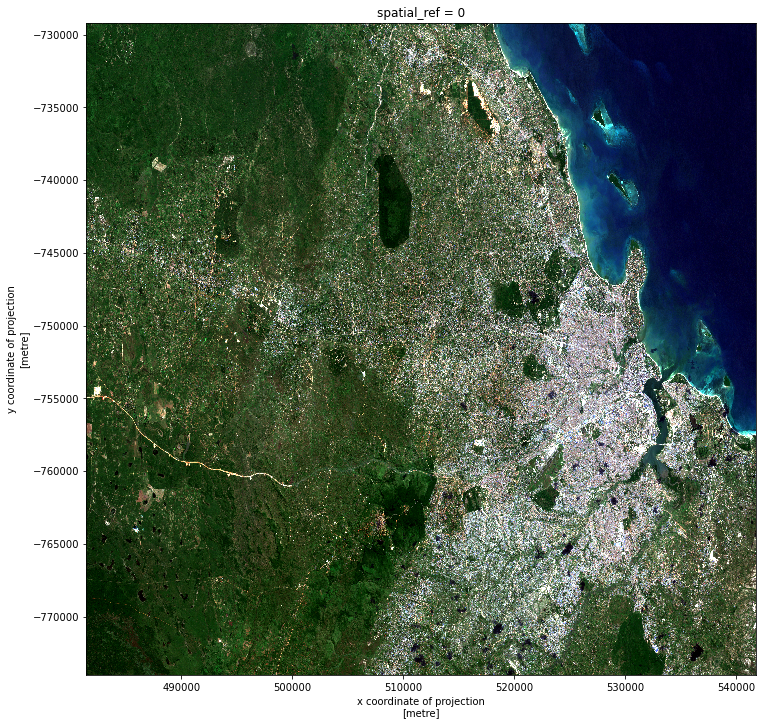

In [18]:
sub.groupby("band")\
   .map(minmax)\
   .plot.imshow(figsize=(12, 12));

## Houston

In [6]:
meta = tiles[tiles.intersects(houston_extent)]
meta["dst_path"] = meta["URL"].apply(lambda x: local_dir+x.split("/")[-1])
houston.crs

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


<Projected CRS: EPSG:3081>
Name: NAD83 / Texas State Mapping System
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: USA - Texas
- bounds: (-106.66, 25.83, -93.5, 36.5)
Coordinate Operation:
- name: Texas State Mapping System (meters)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [7]:
meta

URL   EPSG UTMtile  \
545  http://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendat...  32614     14R   
548  http://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendat...  32614     14R   
641  http://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendat...  32614     15R   
644  http://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendat...  32614     15R   

         minX       minY       maxX       maxY      size  size_unit  \
545  660690.0  3078460.0   805230.0  3311420.0  1.622868  gigabytes   
548  660690.0  3311420.0   805230.0  3544380.0  1.640507  gigabytes   
641  783420.0  3110150.0  1016380.0  3343110.0  2.369711  gigabytes   
644  783420.0  3343110.0  1016380.0  3576070.0  2.532889  gigabytes   

     size_bytes                                           geometry  \
545  1742541113  POLYGON ((-95.90230 27.79605, -95.83939 29.895...   
548  1761480891  POLYGON ((-95.83939 29.89564, -95.76948 31.994...   
641  2544458322  POLYGON ((-93.75144 28.01641, -93.64399 30.110...   
644  2719669102  POLYGON ((-93.64399 30.11005, -93.52462 32.202...   

                                              dst_path  
545  ../../urbangrammar_samba/sp_sig_concept/ghs_co...  
548  ../../urbangrammar_samba/sp_sig_concept/ghs_co...  
641  ../../urbangrammar_samba/sp_sig_concept/ghs_co...  
644  ../../urbangrammar_samba/sp_sig_concept/ghs_co...

In [25]:
out = meta.apply(utils.process_scene, 
                   axis=1,
                   t_crs="EPSG:3081",
                   progressbar=True,
                  )

14/01/2021 15:35:24 | Working on Tile 14R - File: S2_percentile_UTM_373-0000023296-0000046592.tif

file_sizes: 100%|██████████████████████████| 1.74G/1.74G [00:25<00:00, 69.2MB/s]
Successfully downloaded file to ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_373-0000023296-0000046592.tif
	14/01/2021 15:35:50 | rio warp ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_373-0000023296-0000046592.tif ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_373-0000023296-0000046592_osgb.tif --threads 16 --dst-crs EPSG:3081
	14/01/2021 15:39:19 | rm ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_373-0000023296-0000046592.tif
	Split-opt.
		14/01/2021 15:40:49 | Optimising S2_percentile_UTM_373-0000023296-0000046592_wm_R.tif
		14/01/2021 15:42:45 | Optimising S2_percentile_UTM_373-0000023296-0000046592_wm_G.tif
		14/01/2021 15:44:41 | Optimising S2_percentile_UTM_373-0000023296-0000046592_wm_B.

In [36]:
r = rioxarray.open_rasterio("../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_373-0000000000-0000046592_osgb.tif")

In [37]:
sub = r.sel(band=[1, 2, 3]).rio.clip_box(*houston.total_bounds)

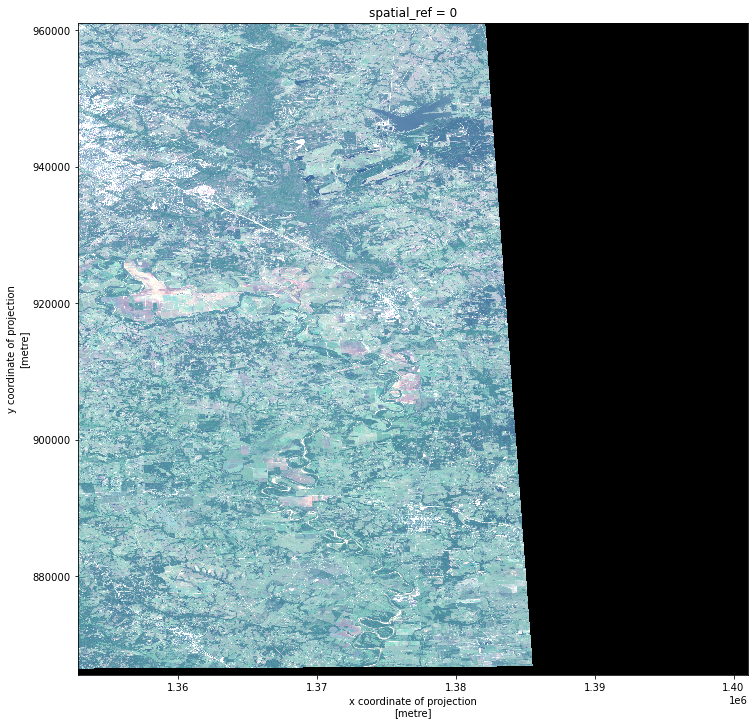

In [38]:
sub.groupby("band")\
   .map(minmax)\
   .plot.imshow(figsize=(12, 12))

<AxesSubplot:>

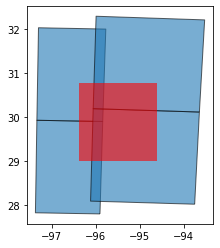

In [12]:
ax = meta.plot(alpha=.6, edgecolor='k')
geopandas.GeoSeries([box(*houston_extent.bounds)]).plot(ax=ax, alpha=.6, color='r')

In [18]:
row = meta.iloc[0]

In [21]:
download(row["URL"], row["dst_path"])


file_sizes: 100%|██████████████████████████| 1.74G/1.74G [01:03<00:00, 27.3MB/s]
Successfully downloaded file to ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_373-0000023296-0000046592.tif


'../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_373-0000023296-0000046592.tif'

In [51]:
for index, row in meta.iloc[1:].iterrows():
    download(row["URL"], row["dst_path"])


file_sizes: 100%|██████████████████████████| 1.76G/1.76G [00:25<00:00, 68.5MB/s]
Successfully downloaded file to ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_373-0000000000-0000046592.tif

file_sizes: 100%|██████████████████████████| 2.54G/2.54G [00:56<00:00, 44.8MB/s]
Successfully downloaded file to ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_30_UTM_374-0000023296-0000000000.tif

file_sizes: 100%|██████████████████████████| 2.72G/2.72G [01:44<00:00, 26.0MB/s]
Successfully downloaded file to ../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_30_UTM_374-0000000000-0000000000.tif


In [9]:
extent = geopandas.GeoSeries(box(*houston.total_bounds), crs=houston.crs).to_crs('epsg:32614').iloc[0]

In [54]:
r = rioxarray.open_rasterio("../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_percentile_UTM_373-0000023296-0000046592.tif")

In [66]:
sub = r.rio.clip([mapping(extent)])

In [10]:
arrays = []
for path in meta.dst_path:
    r = rioxarray.open_rasterio(path)
    sub = r.rio.clip([mapping(extent)])
    arrays.append(sub)

In [12]:
from rioxarray.merge import merge_arrays

In [13]:
merged = merge_arrays(arrays)

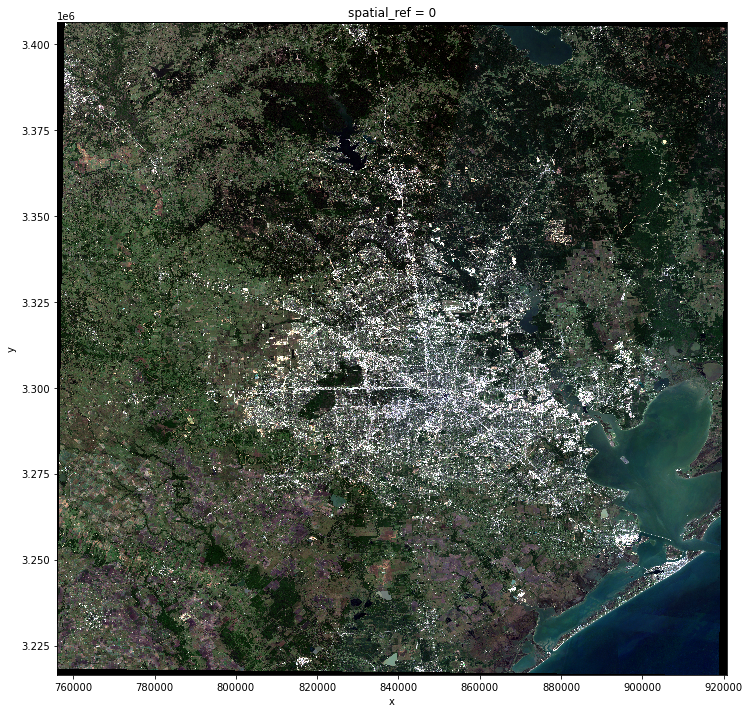

In [21]:
merged.sel(band=[1, 2, 3]).groupby("band")\
   .map(minmax)\
   .plot.imshow(figsize=(12, 12))

In [24]:
proj = merged.rio.reproject(houston.crs)

In [26]:
proj.rio.to_raster("../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_houston_clipped_proj.tif")

In [83]:
masked = proj.where(proj != 0)

In [94]:
masked

<xarray.DataArray (band: 4, y: 19148, x: 16669)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x            (x) float64 1.351e+06 1.351e+06 ... 1.517e+06 1.517e+06
  * y            (y) float64 9.626e+05 9.626e+05 ... 7.717e+05 7.717e+05
  * band         (band) int64 1 2 3 4
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('red_p25', 'green_p25', 'blue_p25', 'nir_p25')
    grid_mapping:  spatial_ref
    _FillValue:    0

In [84]:
ndvi = (masked.sel(band=4) - masked.sel(band=1)) / (masked.sel(band=4) + masked.sel(band=1))

In [89]:
affine = ndvi.rio.transform()

In [37]:
import rasterstats

In [90]:
%%time
stats = rasterstats.zonal_stats(
    houston.geometry, 
    raster=ndvi.values,
    affine=affine,
    stats=['mean'],
    all_touched=True,
    nodata = np.nan,
)

CPU times: user 5min 53s, sys: 11.5 s, total: 6min 5s
Wall time: 6min 5s


In [91]:
houston['ndvi'] = [x["mean"] for x in stats]

In [92]:
houston[['eID', 'ndvi']].to_parquet("../../urbangrammar_samba/sp_sig_concept/houston/ndvi.pq")

<AxesSubplot:>

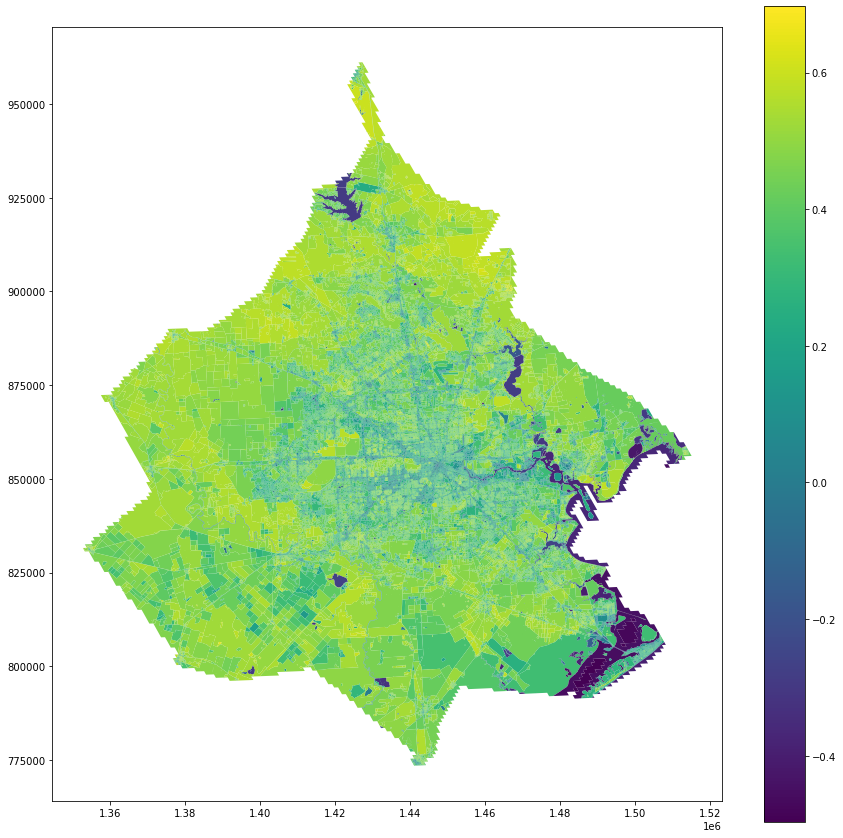

In [93]:
houston.plot('ndvi', figsize=(15, 15), legend=True)